In [184]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

#### Data

In [177]:
resolution = '5m'
#perps = ['ETH-PERP', 'ADA-PERP', 'BNB-PERP', 'LINK-PERP', 'TRX-PERP', 'XRP-PERP', 'DOT-PERP', 'LTC-PERP', 'BCH-PERP', 'EOS-PERP']
#perps = ['ZEC-PERP', 'XMR-PERP']
perps = ['DEFI-PERP', 'SOL-PERP']

ohlc = {}
prices = {}
for perp in perps:
    data = []
    try:
        data = pd.read_parquet('C:/Users/Walid/Desktop/Workspace/data/{}_{}.parquet.gzip'.format(perp, resolution))
    except:
        print('Cannot find {} data'.format(perp))
    
    if len(data) > 0:
        data['startTime'] = data['startTime'].apply(lambda x: datetime.fromisoformat(x))
        ohlc[perp] = data.set_index('startTime')
        prices[perp] = ohlc[perp]['close']

prices = pd.DataFrame(prices).dropna()

#### Mean reversion (static)

##### Trading Signals

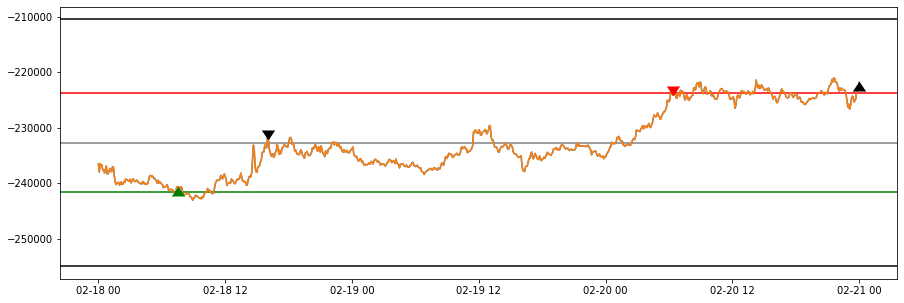

In [162]:
formation_start_time = datetime.fromisoformat('2022-02-18 00:00:00+00:00')
formation_end_time = datetime.fromisoformat('2022-02-21 00:00:00+00:00')
trading_start_time = datetime.fromisoformat('2022-02-18 00:00:00+00:00')
trading_end_time = datetime.fromisoformat('2022-02-21 00:00:00+00:00')


# Make mean reverting portfolio
formation_prices = prices[formation_start_time:formation_end_time]
jres = coint_johansen(formation_prices, 0, 1)
cointegrated = jres.max_eig_stat[0] > jres.max_eig_stat_crit_vals[0][1]
evec = jres.evec[0]
formation_portfolio = (evec * formation_prices).sum(axis=1)
formation_mean = formation_portfolio.mean()
formation_std = formation_portfolio.std()

trading_prices = prices[trading_start_time:trading_end_time]
trading_portfolio = (evec * trading_prices).sum(axis=1)


# Trading positions
positions = [0, 0]
std_multiple = 1.5
long_signal = formation_mean - formation_std * std_multiple
short_signal = formation_mean + formation_std * std_multiple
exit_signal = formation_mean
long_stop_signal = formation_mean - formation_std * std_multiple * 2.5
short_stop_signal = formation_mean + formation_std * std_multiple * 2.5
for i in range(2, len(trading_portfolio.index)):
    if trading_portfolio.iloc[i-2] < long_signal and trading_portfolio.iloc[i-1] > long_signal:
        # open long
        positions.append(1)
    elif trading_portfolio.iloc[i-2] > short_signal and trading_portfolio.iloc[i-1] < short_signal:
        # open short
        positions.append(-1)
    elif positions[i-2] == 1 and trading_portfolio.iloc[i-1] > exit_signal:
        # close long
        positions.append(0)
    elif positions[i-1] == -1 and trading_portfolio.iloc[i-1] < exit_signal:
        # close short
        positions.append(0)
    elif positions[i-1] == 1 and trading_portfolio.iloc[i-1] < long_stop_signal:
        # Take loss
        positions.append(0)
    elif positions[i-1] == -1 and trading_portfolio.iloc[i-1] > short_stop_signal:
        # Take loss
        positions.append(0)
    else:
        positions.append(positions[i-1])


taker_fee = 0.0007
trades = []
for i in range(1, len(positions)):
    # Position opened
    if positions[i-1] == 0 and positions[i] != 0:
        open_spread = trading_portfolio.iloc[i]
        open_trade_index = i

    # Position closed (force close if at last trading bar)
    if positions[i-1] != 0 and (positions[i] == 0 or i == len(positions) - 1):
        open_spread = trading_portfolio.iloc[open_trade_index]
        close_spread = trading_portfolio.iloc[i]
        pnl = ((close_spread - close_spread * taker_fee) - (open_spread - open_spread * taker_fee)) * positions[i-1]

        trades.append({
            'position': 'long' if positions[i-1] > 0 else 'short',
            'open_date': trading_portfolio.index[open_trade_index],
            'open_spread': open_spread,
            'close_date': trading_portfolio.index[i],
            'close_spread': close_spread,
            'pnl': pnl,
            'duration': trading_portfolio.index[i] - trading_portfolio.index[open_trade_index],
            'weights': evec
        })

        open_trade_index = None


trades = pd.DataFrame(trades)


# Visualize
plt.figure(figsize=(15,5))
plt.plot(formation_portfolio)
plt.axhline(short_signal, color='r')
plt.axhline(long_signal, color='g')
plt.axhline(formation_mean, color='grey')
plt.axhline(short_stop_signal, color='black')
plt.axhline(long_stop_signal, color='black')

plt.plot(trading_portfolio)

if len(trades) > 0:
    longs_open_markers = trades.loc[trades['position'] == 'long', 'open_date':'open_spread'].set_index('open_date')
    longs_close_markers = trades.loc[trades['position'] == 'long', 'close_date':'close_spread'].set_index('close_date')
    shorts_open_markers = trades.loc[trades['position'] == 'short', 'open_date':'open_spread'].set_index('open_date')
    shorts_close_markers = trades.loc[trades['position'] == 'short', 'close_date':'close_spread'].set_index('close_date')

    plt.plot(longs_open_markers, linestyle='None', marker=6, color='g', markersize=12)
    plt.plot(longs_close_markers, linestyle='None', marker=7, color='black', markersize=12)
    plt.plot(shorts_open_markers, linestyle='None', marker=7, color='r', markersize=12)
    plt.plot(shorts_close_markers, linestyle='None', marker=6, color='black', markersize=12)
    



##### PNL Calculation

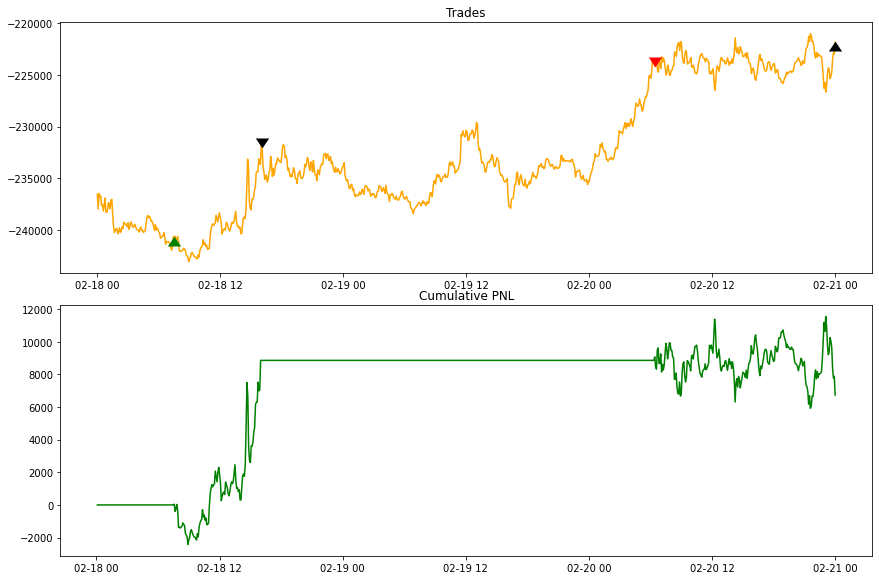

In [163]:
trades_pnl = trading_portfolio.diff() * positions
cumulative_pnl = trades_pnl.cumsum()

fig, axes = plt.subplots(2,1, figsize=(12,8))
fig.tight_layout()
axes[0].plot(trading_portfolio, color='orange')
axes[0].title.set_text("Trades")
axes[0].plot(longs_open_markers, linestyle='None', marker=6, color='g', markersize=12)
axes[0].plot(longs_close_markers, linestyle='None', marker=7, color='black', markersize=12)
axes[0].plot(shorts_open_markers, linestyle='None', marker=7, color='r', markersize=12)
axes[0].plot(shorts_close_markers, linestyle='None', marker=6, color='black', markersize=12)

axes[1].plot(cumulative_pnl, color='g' if cumulative_pnl.iloc[-1] > 0 else 'r')
axes[1].title.set_text("Cumulative PNL")



In [164]:
trades

,position,open_date,open_spread,close_date,close_spread,pnl,duration,weights
0,long,2022-02-18 07:30:00+00:00,-240634.108672,2022-02-18 16:05:00+00:00,-231994.530696,8633.530271,0 days 08:35:00,"[191.20792110975597, -75.31922340298068, 53.55..."
1,short,2022-02-20 06:25:00+00:00,-224189.227779,2022-02-21 00:00:00+00:00,-221849.279513,-2338.310303,0 days 17:35:00,"[191.20792110975597, -75.31922340298068, 53.55..."


#### Trades Statistics

In [165]:
print('Trades Statistics')

avg_win = trades[trades['pnl'] > 0]['pnl'].mean()
avg_loss = trades[trades['pnl'] < 0]['pnl'].mean()
avg_trade_pnl = trades['pnl'].mean()
avg_win_duration = trades[trades['pnl'] > 0]['duration'].mean()
avg_loss_duration = trades[trades['pnl'] < 0]['duration'].mean()
avg_duration = trades['duration'].mean()

print('Average: win pnl = {:.2f}, loss pnl = {:.2f}, trade pnl = {:.2f}, win duration = {}, loss duration = {}, trade duration = {}'.format(avg_win, avg_loss, avg_trade_pnl, avg_win_duration, avg_loss_duration, avg_duration))

median_win = trades[trades['pnl'] > 0]['pnl'].median()
median_loss = trades[trades['pnl'] < 0]['pnl'].median()
median_trade_pnl = trades['pnl'].median()
median_win_duration = trades[trades['pnl'] > 0]['duration'].median()
median_loss_duration = trades[trades['pnl'] < 0]['duration'].median()
median_duration = trades['duration'].median()

print('Median: win pnl = {:.2f}, loss pnl = {:.2f}, trade pnl = {:.2f}, win duration = {}, loss duration = {}, trade duration = {}'.format(median_win, median_loss, median_trade_pnl, median_win_duration, median_loss_duration, median_duration))

Trades Statistics
Average: win pnl = 8633.53, loss pnl = -2338.31, trade pnl = 3147.61, win duration = 0 days 08:35:00, loss duration = 0 days 17:35:00, trade duration = 0 days 13:05:00
Median: win pnl = 8633.53, loss pnl = -2338.31, trade pnl = 3147.61, win duration = 0 days 08:35:00, loss duration = 0 days 17:35:00, trade duration = 0 days 13:05:00


#### Mean Reversion (Rolling)

##### Trading signals

In [186]:
def get_prices(perps, resolution='5m'):
    ohlc = {}
    prices = {}
    for perp in perps:
        data = []
        try:
            data = pd.read_parquet('C:/Users/Walid/Desktop/Workspace/data/{}_{}.parquet.gzip'.format(perp, resolution))
        except:
            print('Cannot find {} data'.format(perp))
        
        if len(data) > 0:
            data['startTime'] = data['startTime'].apply(lambda x: datetime.fromisoformat(x))
            ohlc[perp] = data.set_index('startTime')
            prices[perp] = ohlc[perp]['close']

    prices = pd.DataFrame(prices).dropna()

    return prices


def mean_reversion_rolling_backtest(prices, std_multiple, taker_fee, formation_window_hours, trading_window_hours, formation_start_time, backtest_end_time, visualize):

    formation_end_time = formation_start_time + timedelta(hours=formation_window_hours)
    trades = []
    all_formation_prices = []
    all_trading_prices = []
    while formation_end_time < backtest_end_time:
        
        # Make mean reverting portfolio
        formation_prices = prices[formation_start_time:formation_end_time]
        if len(formation_prices) == 0:
            continue
        jres = coint_johansen(formation_prices, 0, 1)
        cointegrated = jres.max_eig_stat[0] > jres.max_eig_stat_crit_vals[0][1]
        evec = jres.evec[0]
        formation_portfolio = (evec * formation_prices).sum(axis=1)
        formation_mean = formation_portfolio.mean()
        formation_std = formation_portfolio.std()

        trading_start_time = formation_end_time
        trading_end_time = formation_end_time + timedelta(hours=trading_window_hours)
        trading_prices = prices[trading_start_time:trading_end_time]
        trading_portfolio = (evec * trading_prices).sum(axis=1)


        # Trading positions
        positions = [0, 0]
        long_signal = formation_mean - formation_std * std_multiple
        short_signal = formation_mean + formation_std * std_multiple
        exit_signal = formation_mean
        long_stop_signal = formation_mean - formation_std * std_multiple * 20
        short_stop_signal = formation_mean + formation_std * std_multiple * 20
        for i in range(2, len(trading_portfolio.index)):
            if trading_portfolio.iloc[i-2] < long_signal and trading_portfolio.iloc[i-1] > long_signal:
                # open long
                positions.append(1)
            elif trading_portfolio.iloc[i-2] > short_signal and trading_portfolio.iloc[i-1] < short_signal:
                # open short
                positions.append(-1)
            elif positions[i-2] == 1 and trading_portfolio.iloc[i-1] > exit_signal:
                # close long
                positions.append(0)
            elif positions[i-1] == -1 and trading_portfolio.iloc[i-1] < exit_signal:
                # close short
                positions.append(0)
            elif positions[i-1] == 1 and trading_portfolio.iloc[i-1] < long_stop_signal:
                # Take loss
                positions.append(0)
            elif positions[i-1] == -1 and trading_portfolio.iloc[i-1] > short_stop_signal:
                # Take loss
                positions.append(0)
            else:
                positions.append(positions[i-1])


        #trades = []
        for i in range(1, len(positions)):
            # Position opened
            if positions[i-1] == 0 and positions[i] != 0:
                open_spread = trading_portfolio.iloc[i]
                open_trade_index = i

            # Position closed (force close if at last trading bar)
            if positions[i-1] != 0 and (positions[i] == 0 or i == len(positions) - 1):
                open_spread = trading_portfolio.iloc[open_trade_index]
                close_spread = trading_portfolio.iloc[i]
                pnl = ((close_spread - close_spread * taker_fee) - (open_spread - open_spread * taker_fee)) * positions[i-1]

                trades.append({
                    'position': 'long' if positions[i-1] > 0 else 'short',
                    'open_date': trading_portfolio.index[open_trade_index],
                    'open_spread': open_spread,
                    'close_date': trading_portfolio.index[i],
                    'close_spread': close_spread,
                    'pnl': pnl,
                    'duration': trading_portfolio.index[i] - trading_portfolio.index[open_trade_index],
                    'weights': evec
                })

                open_trade_index = None
        
        # Next period
        formation_start_time = formation_start_time + timedelta(hours=trading_window_hours)
        formation_end_time = formation_end_time + timedelta(hours=trading_window_hours)
        all_formation_prices.append(formation_prices*evec)
        all_trading_prices.append(trading_prices*evec)


    trades = pd.DataFrame(trades)

    # stats
    winrate = len(trades[trades['pnl'] > 0]) / len(trades)
    avg_win = trades[trades['pnl'] > 0]['pnl'].mean()
    avg_loss = trades[trades['pnl'] < 0]['pnl'].mean()
    avg_trade_pnl = trades['pnl'].mean()
    avg_win_duration = trades[trades['pnl'] > 0]['duration'].mean()
    avg_loss_duration = trades[trades['pnl'] < 0]['duration'].mean()
    avg_duration = trades['duration'].mean()
    median_win = trades[trades['pnl'] > 0]['pnl'].median()
    median_loss = trades[trades['pnl'] < 0]['pnl'].median()
    median_trade_pnl = trades['pnl'].median()
    median_win_duration = trades[trades['pnl'] > 0]['duration'].median()
    median_loss_duration = trades[trades['pnl'] < 0]['duration'].median()
    median_duration = trades['duration'].median()


    # Visualize
    if visualize:
        fig, axs = plt.subplots(2,1, figsize=(12,8))
        fig.tight_layout()
        axs[0].plot(trades['close_date'], trades['pnl'].cumsum())
        axs[0].title.set_text('Cumulative PNL in dollars per unit ({} hours formation and {} hours trading)'.format(formation_window_hours, trading_window_hours))
        axs[1].hist(trades['pnl'], bins=25)
        axs[1].title.set_text('Trade PNL in dollars per unit')

        print('Trade Statistics')
        
        print('winrate = {:.2f}%'.format(winrate*100))

        print('Average: win pnl = {:.2f}, loss pnl = {:.2f}, trade pnl = {:.2f}, win duration = {}, loss duration = {}, trade duration = {}'.format(avg_win, avg_loss, avg_trade_pnl, avg_win_duration, avg_loss_duration, avg_duration))

        print('Median: win pnl = {:.2f}, loss pnl = {:.2f}, trade pnl = {:.2f}, win duration = {}, loss duration = {}, trade duration = {}'.format(median_win, median_loss, median_trade_pnl, median_win_duration, median_loss_duration, median_duration))


    stats = {
        'pnl': trades['pnl'].cumsum().iloc[-1],
        'winrate': winrate,
        'avg_win': avg_win,
        'avg_loss': avg_loss,
        'avg_duration': avg_duration
    }
    
    return stats



Trade Statistics
winrate = 52.00%
Average: win pnl = 1.95, loss pnl = -2.72, trade pnl = -0.29, win duration = 0 days 04:58:36.923076923, loss duration = 0 days 04:51:55, trade duration = 0 days 04:55:24
Median: win pnl = 0.89, loss pnl = -1.14, trade pnl = 0.03, win duration = 0 days 05:30:00, loss duration = 0 days 05:32:30, trade duration = 0 days 05:30:00


{'pnl': -36.01204621680756,
 'winrate': 0.52,
 'avg_win': 1.9539869783053974,
 'avg_loss': -2.71701999677764,
 'avg_duration': Timedelta('0 days 04:55:24')}

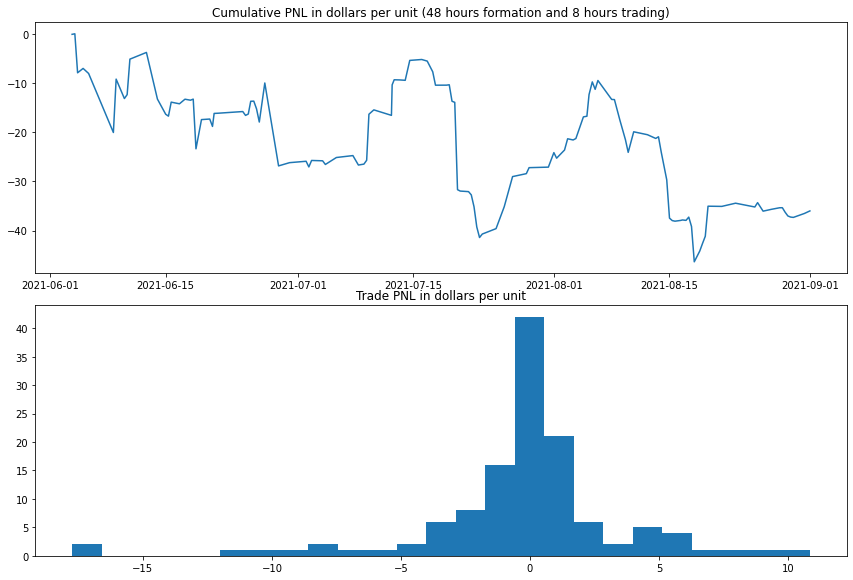

In [191]:
perps = ['BCH-PERP', 'EOS-PERP', 'LTC-PERP']
prices = get_prices(perps, '5m')
mean_reversion_rolling_backtest(prices, 1.5, 0.0007, 48, 8, datetime.fromisoformat('2021-06-01 00:00:00+00:00'), datetime.fromisoformat('2021-09-01 00:00:00+00:00'), True)

[Text(69.0, 0.5, 'Formation Window (hours)'),
 Text(0.5, 42.0, 'Trading Window (hours)')]

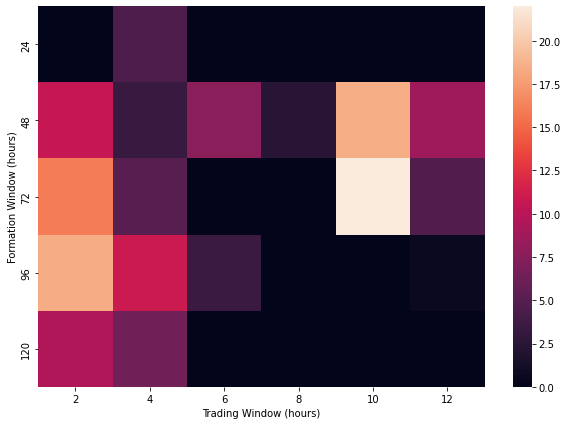

In [178]:
fee = 0.0007
start_date = datetime.fromisoformat('2021-06-01 00:00:00+00:00')
end_date = datetime.fromisoformat('2021-09-01 00:00:00+00:00')
formation_window_hours_range = range(24,6*24,24)
trading_window_hours_range = range(2,13,2)

pnl_matrix = pd.DataFrame(index=formation_window_hours_range, columns=trading_window_hours_range)
winrate_matrix = pd.DataFrame(index=formation_window_hours_range, columns=trading_window_hours_range)
for formation in formation_window_hours_range:
    for trading in trading_window_hours_range:
        stats = mean_reversion_rolling_backtest(1, fee, formation, trading, start_date, end_date, False)
        pnl_matrix.loc[formation][trading] = stats['pnl']
        winrate_matrix.loc[formation][trading] = stats['winrate']

plt.figure(figsize=(10,7))
hm = sns.heatmap(pnl_matrix.astype(float), vmin=0)
hm.set(ylabel='Formation Window (hours)', xlabel='Trading Window (hours)')
